# Concolutional Neural Network

## Importation librairies

In [1]:
import numpy as np

from tensorflow.keras.utils import normalize, to_categorical, plot_model
from tensorflow.keras.layers import Input, Conv1D, Activation, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras import models, callbacks

import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

## Importation et affichage données

health: -1.0
[ 0.50205548  0.54216265  0.72238348  1.4288852   2.1365158   2.281149
  1.9362737   1.46889     1.0088451   0.38028224 -0.29677967 -0.51392868
 -0.25564469 -0.10720254 -0.28782655 -0.41800901 -0.31916313 -0.2603787
 -0.35035721 -0.50548599 -0.71088709 -0.82391982 -0.89970154 -1.1539497
 -1.2298306  -1.044091   -1.2020312  -1.3921949  -1.1301083  -1.1798666
 -1.6492718  -1.7265754  -1.6083704  -1.6628022  -1.6506724  -1.6973094
 -1.8386968  -1.8025962  -1.7805361  -1.8251665  -1.6447633  -1.4238097
 -1.3921949  -1.3604156  -1.2001781  -0.91863234 -0.68591581 -0.66794346
 -0.51272154 -0.10169069  0.06395426  0.08261431  0.23760718  0.17479318
  0.12320539  0.5033942   0.6838702   0.47499476  0.53279711  0.72354995
  0.6644198   0.64793559  0.75705403  0.7320716   0.62021499  0.60629677
  0.67795016  0.68908363  0.59880728  0.54264656  0.58180737  0.63063068
  0.6644198   0.6863178   0.65738251  0.65088944  0.72173837  0.73970645
  0.69148052  0.69522947  0.7501145   0.85384

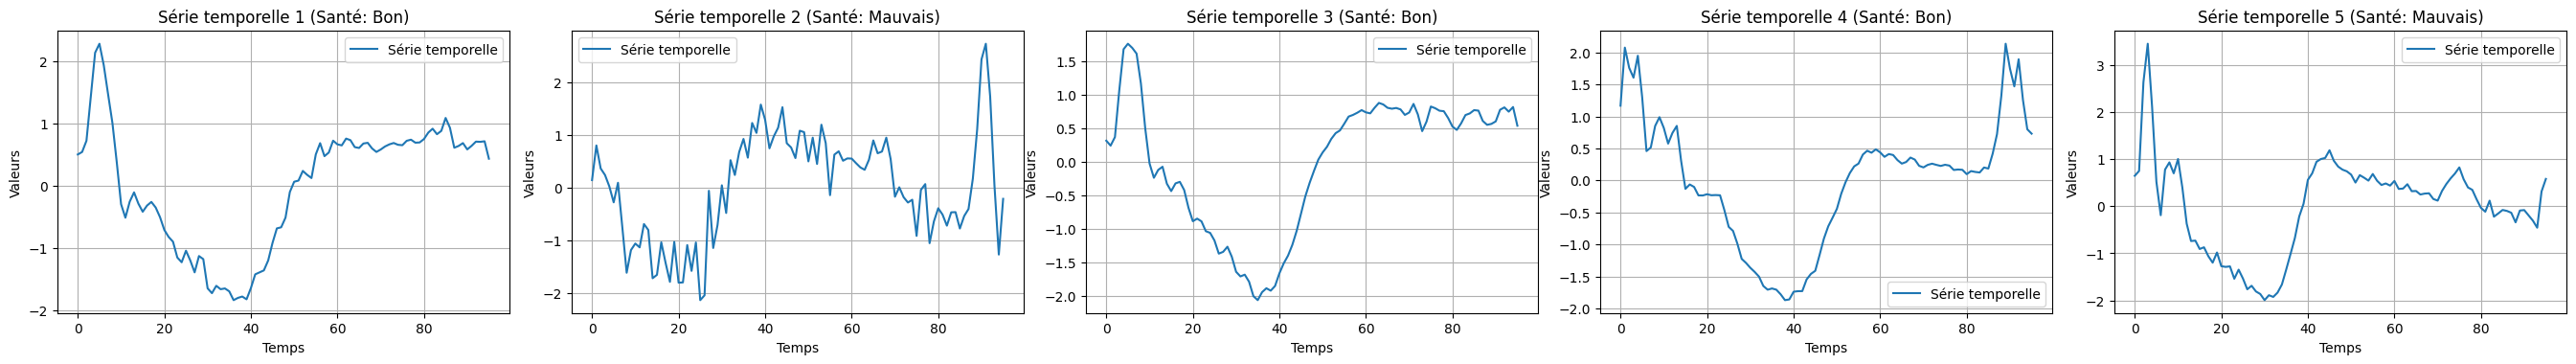

In [2]:
train_data = np.loadtxt('data/ECG200_TRAIN.tsv', delimiter='\t')
test_data = np.loadtxt('data/ECG200_TEST.tsv', delimiter='\t')

# Afficher la première série temporelle
print("health:", train_data[0,0])
print(train_data[0,1:])

# Afficher les dimensions des données
print("Dimensions des données d'entrainnement:", train_data.shape)
print("Dimensions des données de test:", test_data.shape)

# Afficher les 5 premières séries temporelles
nb_series_a_afficher = 5
plt.figure(figsize=(27, 7))
for i in range(nb_series_a_afficher):
    # Extraire la série temporelle et son état de santé correspondant
    serie_temporelle = train_data[i, 1:]
    etat_sante = train_data[i, 0]
    
    # Créer une plage de temps pour l'axe x
    plage_temps = range(len(serie_temporelle))
    
    # Placer la série temporelle dans le sous-graphique correspondant
    plt.subplot(2, nb_series_a_afficher, i+1)
    plt.plot(plage_temps, serie_temporelle, label='Série temporelle')
    plt.xlabel('Temps')
    plt.ylabel('Valeurs')
    plt.title(f'Série temporelle {i+1} (Santé: {"Bon" if etat_sante == -1 else "Mauvais"})')
    plt.legend()
    plt.grid(True)

# Ajuster automatiquement les espaces entre les sous-graphiques
plt.tight_layout()
plt.show()



## Traitement données

In [3]:
"""# Normaliser les série temporelle entre 0 et 1 dépendament des autres
X_train_normalized = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))
X_test_normalized = (X_test - np.min(X_test)) / (np.max(X_test) - np.min(X_test))"""

'# Normaliser les série temporelle entre 0 et 1 dépendament des autres\nX_train_normalized = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))\nX_test_normalized = (X_test - np.min(X_test)) / (np.max(X_test) - np.min(X_test))'

In [4]:
# Normaliser les classe
train_data[train_data[:, 0] == -1, 0] = 0
test_data[test_data[:, 0] == -1, 0] = 0

# Séparation des données d'entrainnements et de tests
X_train, y_train = train_data[:, 1:], train_data[:, 0]
X_test, y_test = test_data[:, 1:], test_data[:, 0]

# Normaliser les série temporelle entre 0 et 1 indépendament
X_train_normalized = normalize(X_train, axis=1)
X_test_normalized = normalize(X_test, axis=1)

# Convertir les étiquettes en encodage one-hot
y_train_encoded = to_categorical(y_train, num_classes=2)
y_test_encoded = to_categorical(y_test, num_classes=2)

# Afficher la première série temporelle
print("health:", y_train_encoded[0])
print(X_train_normalized[0])
print("Dimensions des données d'entrainnement:", (X_train_normalized.shape, y_train_encoded.shape))


health: [1. 0.]
[ 0.05150981  0.05562471  0.07411498  0.14660053  0.2192019   0.23404095
  0.19865749  0.15070493  0.10350532  0.03901613 -0.03044895 -0.05272797
 -0.02622859 -0.01099875 -0.02953038 -0.04288682 -0.03274545 -0.02671429
 -0.03594589 -0.05186177 -0.07293548 -0.08453239 -0.09230743 -0.11839274
 -0.12617796 -0.10712148 -0.1233258  -0.14283618 -0.11594667 -0.12105176
 -0.16921172 -0.1771429  -0.16501532 -0.17059991 -0.16935542 -0.17414027
 -0.18864631 -0.18494247 -0.18267915 -0.18725813 -0.16874915 -0.14607979
 -0.14283618 -0.1395757  -0.12313568 -0.09424969 -0.07037348 -0.06852955
 -0.05260412 -0.01043324  0.00656157  0.00847605  0.02437798  0.0179334
  0.01264061  0.05164716  0.0701636   0.04873343  0.05466383  0.07423466
  0.06816803  0.06647679  0.0776721   0.07510896  0.06363272  0.06220474
  0.06955622  0.07069849  0.06143633  0.05567436  0.05969218  0.06470134
  0.06816803  0.07041472  0.06744602  0.06677985  0.07404879  0.07589228
  0.0709444   0.07132904  0.07696012

## Choix des Hyperparamètres

❒ Les hyperparamètres des layers : kernel size, dropout, méthode d’activation des layers cachés, méthode d’activation du layer final, …

❒ Les hyperparamètres de compilation du modèle: optimizer, loss, learning rate …

❒ Les hyperparamètres d’exécution du modèle : batch size, nombre d’epochs, …

In [5]:
# HyperParameter des layers :
filters = 3
kernel_size = 2
stride = 1
padding = 'same'
hidden_activation = 'relu'
final_activation = 'sigmoid' 
pool_size = 1
dropout_rate = 0.3
nb_classes = 2

# HyperParameter de compilation : 
"""learning_rate = 0.001 """                        # choose learning rate pour l'optimiseur adam
optimizer_algo = 'adam'
cost_function = 'binary_crossentropy'               # ou categorical_crossentropy

## HyperParameter d’exécution : 
mini_batch_size = 16
nb_epochs = 600
percentage_of_train_as_validation = 0.2

## Création du modèle

In [6]:
# input
input_shape = (96, 1)
input_layer = Input(input_shape)

# block
conv_layer_1_1 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding)(input_layer)
relu_layer_1_1 = Activation(hidden_activation)(conv_layer_1_1)
conv_layer_1_2 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding)(relu_layer_1_1)
relu_layer_1_2 = Activation(hidden_activation)(conv_layer_1_2)
pooling_layer_1 = MaxPooling1D(pool_size=pool_size,padding=padding)(relu_layer_1_2)
dropout_layer_1_1 = Dropout(rate=dropout_rate)(relu_layer_1_1)

# output
flattened_layer = Flatten()(pooling_layer_1)
dropout_flattened = Dropout(rate=dropout_rate)(flattened_layer)
output_layer = Dense(units=nb_classes, activation=final_activation)(dropout_flattened)

model = models.Model(inputs=input_layer, outputs=output_layer)

## Compilation du modèle

In [7]:
model.compile(loss=cost_function,optimizer=optimizer_algo, metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 96, 3)          │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 96, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 96, 3)          │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 96, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 96, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           578 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 608 (2.38 KB)

 Trainable params: 608 (2.38 KB)

 Non-trainable params: 0 (0.00 B)

## Entrainnement du modèle

In [8]:
# specify the model checkpoint (to save the best model for each epoch)
model_checkpoint = callbacks.ModelCheckpoint('best_model_CNN.keras', monitor='val_loss', save_best_only=True)

# start training
history = model.fit(X_train_normalized, y_train_encoded, 
                    batch_size=mini_batch_size, 
                    epochs=nb_epochs,
                    validation_split=percentage_of_train_as_validation,
                    verbose=False,
                    callbacks=[model_checkpoint])


## Résultats du modèle

In [9]:

# Charge le meilleur modèle
best_model = models.load_model('best_model_CNN.keras')

# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test_normalized, y_test_encoded)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.8148 - loss: 0.4000   
Test Loss: 0.4289211630821228
Test Accuracy: 0.800000011920929


### Graph

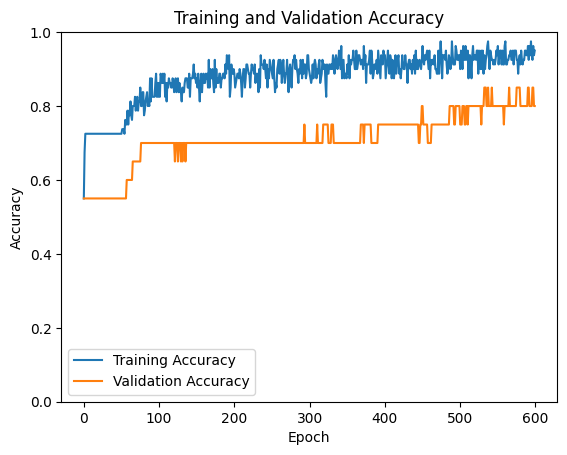

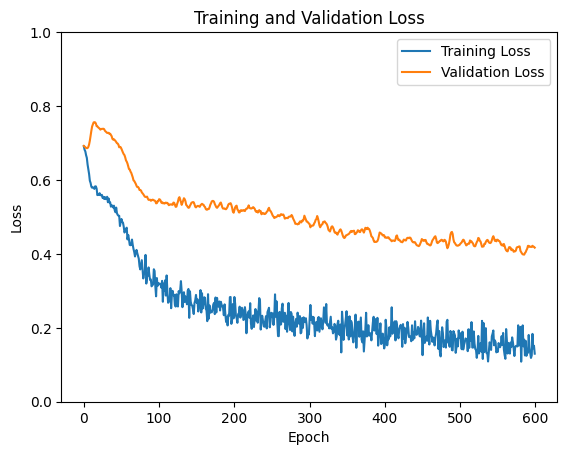

In [10]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.ylim(0, 1)
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.ylim(0, 1)
plt.show()

### Matrice de confusion

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


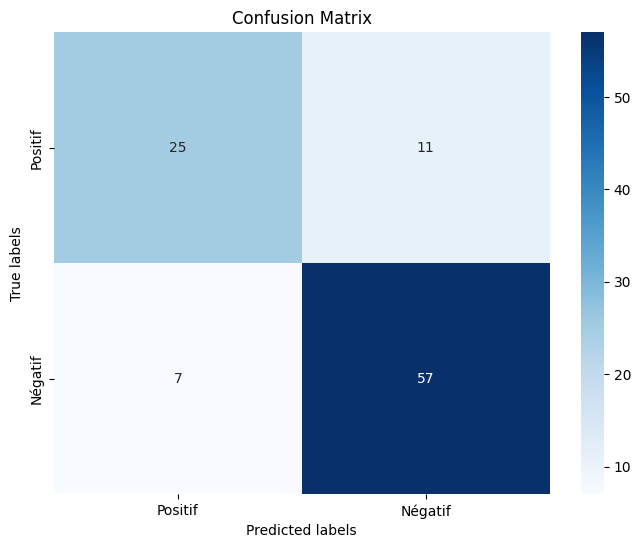

In [11]:
class_names = ['Positif', 'Négatif']

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test_normalized)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)    

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Recherche des hyperparamètre
par recherche par grille et recherche aléatoire (à faire: avec de la validation croisé)


## Meilleur modèle


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.9522 - loss: 0.1228   
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8641 - loss: 0.3446 
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000016E22AE9F80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
You must install graphviz (see instructions at https:

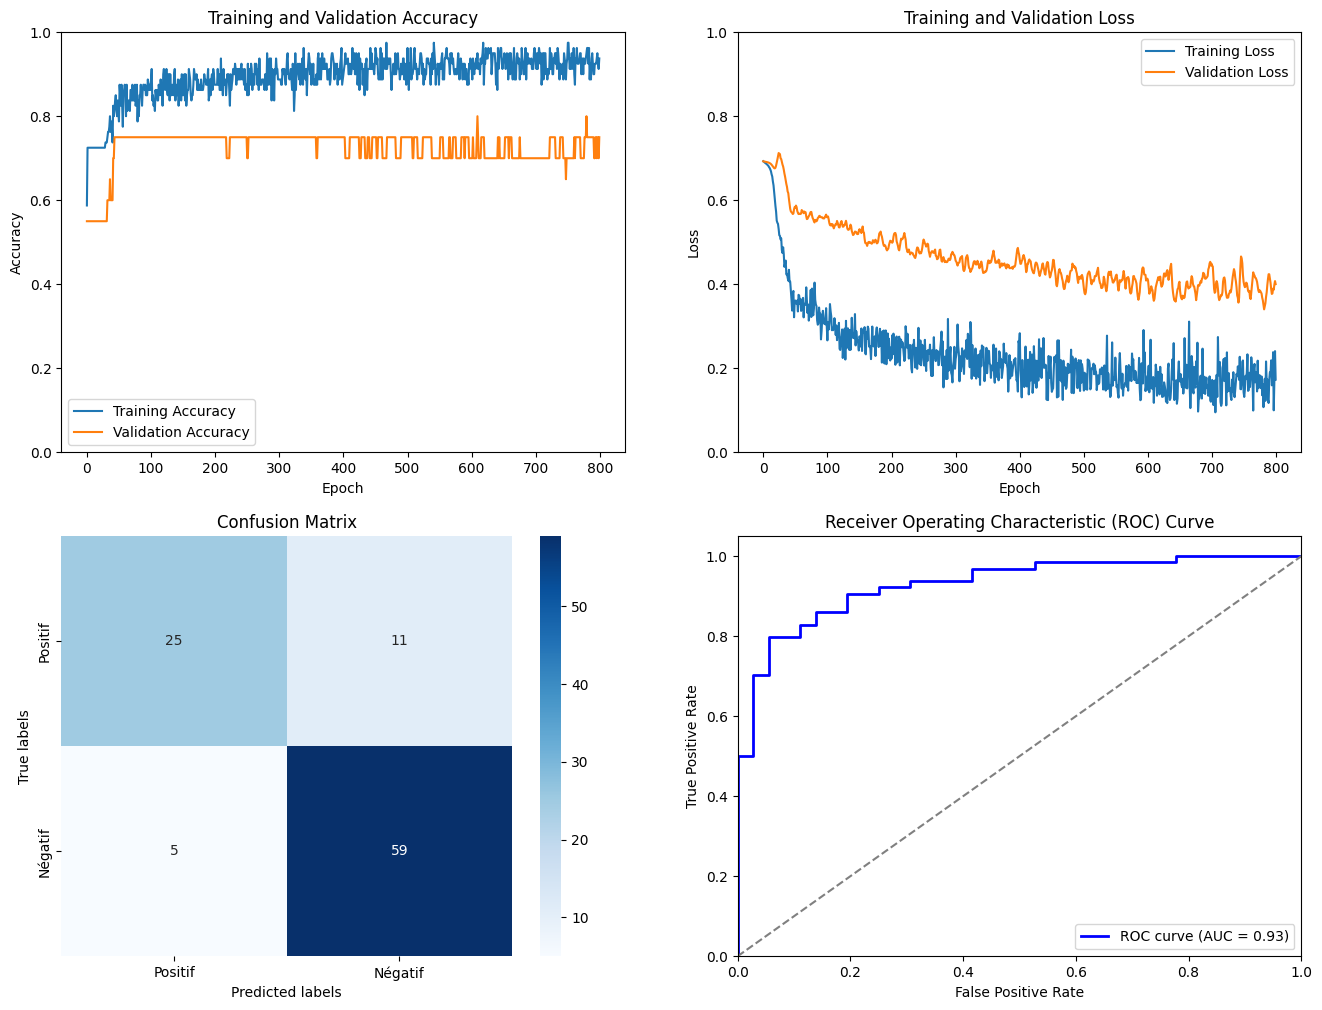

In [13]:
"""
Best hyperparameters:   [(5, 3, 2, 2, 0.2, 16), (5, 3, 1, 1, 0.2, 16), (5, 3, 1, 2, 0.2, 16), 
  (5, 3, 1, 2, 0.2, 16), (5, 3, 1, 2, 0.2, 16), (5, 3, 1, 1, 0.2, 16), (5, 3, 2, 1, 0.2, 16)]
Best hyperparameters 2: [(5, 3, 1, 2, 0.2, 16), (5, 3, 1, 1, 0.2, 16), (5, 3, 2, 1, 0.2, 16), 
  (5, 3, 1, 1, 0.2, 16), (5, 3, 1, 2, 0.2, 16), (5, 3, 1, 2, 0.2, 16)]
Meilleure perte : 0.3860410451889038
Meilleure précision : 0.8700000047683716
Temps d'entraînement des hyperparamètre : 21.0 minutes et 30.839005708694458 secondes.
"""

# hyperparamètres
filters = 5
kernel_size = 3
stride = 1
padding = 'same'
use_bias = False
hidden_activation = 'relu'
final_activation = 'sigmoid' 
pool_size = 2
dropout_rate = 0.2
nb_classes = 2
# learning_rate = 0.006
optimizer_algo = 'adam'  # Adam(learning_rate=learning_rate)
cost_function = 'binary_crossentropy'
mini_batch_size = 16
nb_epochs = 800
percentage_of_train_as_validation = 0.2

# build and compil modelt
input_shape = (96, 1)
input_layer = Input(input_shape)
conv_layer_1_1 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding,use_bias=use_bias)(input_layer)
relu_layer_1_1 = Activation(hidden_activation)(conv_layer_1_1)
conv_layer_1_2 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding,use_bias=use_bias)(relu_layer_1_1)
relu_layer_1_2 = Activation(hidden_activation)(conv_layer_1_2)
pooling_layer_1 = MaxPooling1D(pool_size=pool_size, padding=padding)(relu_layer_1_2)
dropout_layer_1_1 = Dropout(rate=dropout_rate)(pooling_layer_1)
conv_layer_2_1 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding,use_bias=use_bias)(dropout_layer_1_1)
relu_layer_2_1 = Activation(hidden_activation)(conv_layer_2_1)
conv_layer_2_2 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding,use_bias=use_bias)(relu_layer_2_1)
relu_layer_2_2 = Activation(hidden_activation)(conv_layer_2_2)
pooling_layer_2 = MaxPooling1D(pool_size=pool_size, padding=padding)(relu_layer_2_2)
flattened_layer = Flatten()(pooling_layer_2)
dropout_flattened = Dropout(rate=dropout_rate)(flattened_layer)
output_layer = Dense(units=nb_classes,activation=final_activation)(dropout_flattened)
model = models.Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

model_checkpoint = callbacks.ModelCheckpoint('best_model_CNN.keras', monitor='val_loss', save_best_only=True)

# start training
start_time = time.time()
history = model.fit(X_train_normalized, y_train_encoded, 
                    batch_size=mini_batch_size, 
                    epochs=nb_epochs,
                    validation_split=percentage_of_train_as_validation,
                    verbose=False,
                    callbacks=[model_checkpoint])
end_time = time.time()

# Eveluate best model
best_model = models.load_model('best_model_CNN.keras')
train_loss, train_accuracy = best_model.evaluate(X_train_normalized, y_train_encoded)
test_loss, test_accuracy = best_model.evaluate(X_test_normalized, y_test_encoded)


y_pred = best_model.predict(X_test_normalized)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
fpr, tpr, thresholds = roc_curve(y_test_encoded[:, 1], y_pred[:, 1])
roc_auc = auc(fpr, tpr)
class_names = ['Positif', 'Négatif']

# result
plot_model(best_model, show_shapes=True)
training_time_seconds = end_time - start_time
print(f"Nombre total de paramètres : {best_model.count_params()}")
print(f"Temps d'entraînement : {training_time_seconds // 60} minutes et {training_time_seconds % 60} secondes.")
print(f"Test Loss : {test_loss}")
print(f"Test Accuracy : {test_accuracy}")
print(f"AUC-ROC : ", roc_auc)
print(f"Train Loss : {train_loss}")
print(f"Train Accuracy : {train_accuracy}")

# Plot 
plt.figure(figsize=(16, 12))# mettre plus d'espace
# Training and Validation Accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.ylim(0, 1)
# Training and Validation Loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.ylim(0, 1)
# Confusion Matrix
plt.subplot(2, 2, 3)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
# ROC Curve
plt.subplot(2, 2, 4)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')


## Validation croisée

In [14]:
train_data = np.loadtxt('data/ECG200_TRAIN.tsv', delimiter='\t')
test_data = np.loadtxt('data/ECG200_TEST.tsv', delimiter='\t')

test_data[test_data[:, 0] == -1, 0] = 0
X_test, y_test = test_data[:, 1:], test_data[:, 0]
X_test_normalized = normalize(X_test, axis=1)
y_test_encoded = to_categorical(y_test, num_classes=2)

# hyperparamètres
filters = 5
kernel_size = 3
stride = 1
padding = 'same'
use_bias = False
hidden_activation = 'relu'
final_activation = 'sigmoid' 
pool_size = 2
dropout_rate = 0.2
nb_classes = 2
# learning_rate = 0.006
optimizer_algo = 'adam'  # Adam(learning_rate=learning_rate)
cost_function = 'binary_crossentropy'
mini_batch_size = 16
nb_epochs = 800
percentage_of_train_as_validation = 0.2

# Création de 5 ensembles de validation croisée car 20% de validation
num_splits = 5
test_accuracy_vals = []
test_loss_vals = []
train_accuracy_vals = []
train_loss_vals = []

# Mélanger les données
for i in range(num_splits) :
    train_data_suffled = train_data
    np.random.shuffle(train_data_suffled)
    train_data_suffled[train_data_suffled[:, 0] == -1, 0] = 0
    X_train, y_train = train_data_suffled[:, 1:], train_data_suffled[:, 0]
    X_train_normalized = normalize(X_train, axis=1)
    y_train_encoded = to_categorical(y_train, num_classes=2)

    # build and compil model
    input_shape = (96, 1)
    input_layer = Input(input_shape)
    conv_layer_1_1 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding,use_bias=use_bias)(input_layer)
    relu_layer_1_1 = Activation(hidden_activation)(conv_layer_1_1)
    conv_layer_1_2 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding,use_bias=use_bias)(relu_layer_1_1)
    relu_layer_1_2 = Activation(hidden_activation)(conv_layer_1_2)
    pooling_layer_1 = MaxPooling1D(pool_size=pool_size, padding=padding)(relu_layer_1_2)
    dropout_layer_1_1 = Dropout(rate=dropout_rate)(pooling_layer_1)
    conv_layer_2_1 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding,use_bias=use_bias)(dropout_layer_1_1)
    relu_layer_2_1 = Activation(hidden_activation)(conv_layer_2_1)
    conv_layer_2_2 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding,use_bias=use_bias)(relu_layer_2_1)
    relu_layer_2_2 = Activation(hidden_activation)(conv_layer_2_2)
    pooling_layer_2 = MaxPooling1D(pool_size=pool_size, padding=padding)(relu_layer_2_2)
    flattened_layer = Flatten()(pooling_layer_2)
    dropout_flattened = Dropout(rate=dropout_rate)(flattened_layer)
    output_layer = Dense(units=nb_classes,activation=final_activation)(dropout_flattened)
    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
    
    model_checkpoint = callbacks.ModelCheckpoint('best_model_CNN.keras', monitor='val_loss', save_best_only=True)

    # start training
    history = model.fit(X_train_normalized, y_train_encoded, 
                        batch_size=mini_batch_size, 
                        epochs=nb_epochs,
                        validation_split=percentage_of_train_as_validation,
                        verbose=False,
                        callbacks=[model_checkpoint])

    # Eveluate best model
    best_model = models.load_model('best_model_CNN.keras')
    train_loss, train_accuracy = best_model.evaluate(X_train_normalized, y_train_encoded)
    test_loss, test_accuracy = best_model.evaluate(X_test_normalized, y_test_encoded)

    test_accuracy_vals.append(test_accuracy)
    test_loss_vals.append(test_loss)
    train_accuracy_vals.append(train_accuracy)
    train_loss_vals.append(train_loss)

# Affichage des moyennes
print("Moyenne de test_accuracy_vals:", np.mean(test_accuracy_vals))
print("Moyenne de test_loss_vals:", np.mean(test_loss_vals))
print("Moyenne de train_accuracy_vals:", np.mean(train_accuracy_vals))
print("Moyenne de train_loss_vals:", np.mean(train_loss_vals))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8812 - loss: 0.2297  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8332 - loss: 0.3776 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.9696 - loss: 0.0888   
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8240 - loss: 0.3913 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.8853 - loss: 0.2337   
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.8054 - loss: 0.4655
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.8938 - loss: 0.2890   
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7962 - loss: 0.3922 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9908 - loss: 0.1088  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8270 - loss: 0.4038 
Moyenne de test_accuracy_vals: 0.8080000042915344
Moyenne de test_loss_vals: 0.4125413239002228
Moyenne de train_accuracy_vals: 0.9139999985694885
Moyenne de train_loss_vals: 0.20759453475475312
